In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field, plot_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [65]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, L
src = [-0.4, 0.5]
k = 2 * np.pi * 20 / 1500 * 100
L_pml = 0.5
sigma = 3

In [66]:
## hyperparameter
#w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(5e3)
learning_rate = 2e-5

In [67]:
def loss_grad_norm(loss, model):
    loss_grad_norm = 0
    loss_clone = loss.clone()
    for params in model.parameters():
        loss_grad = torch.autograd.grad(loss_clone, params, retain_graph=True, allow_unused=True, materialize_grads=True)[0]
        loss_grad_norm += torch.sum(loss_grad**2)
    loss_grad_norm = loss_grad_norm**0.5
    loss_grad_norm = loss_grad_norm.detach()
    return loss_grad_norm

def update_lambda(model, loss_lst, lamb_lst, alpha):
    grad = []
    for loss in loss_lst:
        grad.append(loss_grad_norm(loss, model))
    grad_sum = sum(grad)
    lamb = []
    for i in range(len(grad)):
        lamb_hat = grad_sum / grad[i]
        if torch.isnan(lamb_hat) or torch.isinf(lamb_hat):
            lamb_hat = torch.ones_like(lamb_hat)
        lamb_new = alpha*lamb_lst[i] + (1-alpha)*lamb_hat
        lamb.append(lamb_new)
    return lamb

In [68]:
def get_dataset(Lx, Ly, device=device):
    # pde
    x0, y0 = 2 * Lx * torch.rand(100000, 1) - Lx, 2 * Ly * torch.rand(100000, 1) - Ly
    x, y = torch.linspace(-Lx, Lx, 250), torch.linspace(-Ly, Ly, 250)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x0[-len(x):, :], y0[-len(x):, :] = x, y
    return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device)

def data_iter(batch_size, x, y):
    import random as rd
    num = len(x)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x[batch_id], y[batch_id]

In [69]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(- y - (Ly - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, k, L_pml=L_pml, sigma0=sigma):
    x, y = x.requires_grad_(), y.requires_grad_()
    xy = torch.cat([x, y], dim=-1)

    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)

    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1].sum(), x, create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2].sum(), x, create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1].sum(), x, create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2].sum(), x, create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1].sum(), y, create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2].sum(), y, create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1].sum(), y, create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2].sum(), y, create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p)
    return (res[:, 0] ** 2).mean(), (res[:, 1] ** 2).mean()

def green(x, y, src, device=device, is_tensor='True'):
    if is_tensor:
        r = torch.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
        r = r.detach().to('cpu').numpy()
        hankel = scipy.special.hankel2(0, k * r + 1e-6)
        g = 0.25j * hankel
        g_real, g_imag = g.real, g.imag
        g_real, g_imag = torch.tensor(g_real, dtype=torch.float32), torch.tensor(g_imag, dtype=torch.float32)
        g = torch.cat([g_real, g_imag], dim=-1).to(device)
    else:
        r = np.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)
        hankel = scipy.special.hankel2(0, k * r + 1e-6)
        g = 0.25j * hankel
        g_real, g_imag = g.real, g.imag
        g = np.concatenate([g_real, g_imag], axis=-1)
    return g

def loss_bd(model, Lx, Ly, src, n_coll=1000, device=device):
    L = Lx# - L_pml
    x, y = torch.linspace(-L, L, n_coll), Ly * torch.ones(n_coll)
    x, y = torch.cat([x, x], dim=-1), torch.cat([y, -y], dim=-1)
    #y[:int(y.shape[0] / 2)] = -y[:int(x.shape[0] / 2)]
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
    y = torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)
    res = p + green(x, y, src)
    return (res ** 2).mean()

In [70]:
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.apply(sine_init)
model.net[0].apply(first_layer_sine_init)
#import joblib
#state_dict = joblib.load('model_green.joblib')
#model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
#model.load_state_dict(state_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lamb = [1, 1, 1]
#loss_bound_hist = []
#loss_pde_hist = []
#loss_src_hist = []
#lamb_bound_hist = []
#lamb_pde_hist = []
#lamb_src_hist = []
l_lst = []
n_lamb_update = 50

In [71]:
n_epochs = int(5e2)
learning_rate = 2e-6
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
#from torch.optim.lr_scheduler import MultiStepLR
#milestones = [1000]
#scheduler = MultiStepLR(optimizer, milestones, gamma=0.1, last_epoch=-1)

In [72]:
model = model.to(device)

In [73]:
x0, y0 = get_dataset(Lx, Ly)
i = 0
for epoch in tqdm(range(n_epochs)):
    if epoch == 1000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    if epoch == 3000:
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
    if epoch == 4000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    for x, y in data_iter(10000, x0, y0):
        optimizer.zero_grad()
        loss_pde1, loss_pde2 = loss_fn(model, x, y, k)
        loss_top = loss_bd(model, Lx, Ly, src)
        loss_lst = [loss_pde1, loss_pde2, loss_top]
        i += 1
        if i % 50 == 0: 
            lamb = update_lambda(model, loss_lst, lamb, 0.9)
        loss = lamb[0] * loss_pde1 + lamb[1] * loss_pde2 + lamb[2] * loss_top
        
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Loss_pde1: {loss_pde1.item()}, Loss_pde2: {loss_pde2.item()}')
    
    l_lst.append(loss)

/tmp/ipykernel_8706/681251068.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_8706/681251068.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device)
/tmp/ipykernel_8706/2119246031.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device)
/tmp/ipykernel_8706/2119246031.py:57: UserWarning: To copy construct from a

Epoch 5, Loss: 3.275470733642578, Loss_pde1: 1.148666501045227, Loss_pde2: 1.1180564165115356


  2%|▏         | 10/500 [00:19<17:19,  2.12s/it]

Epoch 10, Loss: 1.7294261455535889, Loss_pde1: 0.3333044648170471, Loss_pde2: 0.3337693214416504


  3%|▎         | 15/500 [00:28<17:12,  2.13s/it]

Epoch 15, Loss: 1.4560837745666504, Loss_pde1: 0.1872957944869995, Loss_pde2: 0.18942052125930786


  4%|▍         | 20/500 [00:38<17:05,  2.14s/it]

Epoch 20, Loss: 1.3248016834259033, Loss_pde1: 0.12756706774234772, Loss_pde2: 0.1313716024160385


  5%|▌         | 25/500 [00:47<16:58,  2.14s/it]

Epoch 25, Loss: 1.205552339553833, Loss_pde1: 0.09820191562175751, Loss_pde2: 0.10374642163515091


  6%|▌         | 30/500 [00:57<16:50,  2.15s/it]

Epoch 30, Loss: 1.1064038276672363, Loss_pde1: 0.08155691623687744, Loss_pde2: 0.08861042559146881


  7%|▋         | 35/500 [01:07<16:42,  2.16s/it]

Epoch 35, Loss: 1.0373115539550781, Loss_pde1: 0.07387518137693405, Loss_pde2: 0.08238518983125687


  8%|▊         | 40/500 [01:17<16:33,  2.16s/it]

Epoch 40, Loss: 0.9543590545654297, Loss_pde1: 0.06930242478847504, Loss_pde2: 0.07867998629808426


  9%|▉         | 45/500 [01:26<16:24,  2.16s/it]

Epoch 45, Loss: 0.9857808947563171, Loss_pde1: 0.0723903551697731, Loss_pde2: 0.08358060568571091


 10%|█         | 50/500 [01:36<16:40,  2.22s/it]

Epoch 50, Loss: 0.8643620014190674, Loss_pde1: 0.07240065932273865, Loss_pde2: 0.07943874597549438


 11%|█         | 55/500 [01:47<16:43,  2.26s/it]

Epoch 55, Loss: 0.7847266793251038, Loss_pde1: 0.07252271473407745, Loss_pde2: 0.08276314288377762


 12%|█▏        | 60/500 [01:57<16:24,  2.24s/it]

Epoch 60, Loss: 0.974790632724762, Loss_pde1: 0.10424982756376266, Loss_pde2: 0.10978527367115021


 13%|█▎        | 65/500 [02:07<16:12,  2.24s/it]

Epoch 65, Loss: 0.8257116079330444, Loss_pde1: 0.10108448565006256, Loss_pde2: 0.10684573650360107


 14%|█▍        | 70/500 [02:18<17:04,  2.38s/it]

Epoch 70, Loss: 0.7282540798187256, Loss_pde1: 0.10563035309314728, Loss_pde2: 0.10639692097902298


 15%|█▌        | 75/500 [02:29<17:02,  2.41s/it]

Epoch 75, Loss: 0.5931434035301208, Loss_pde1: 0.09603453427553177, Loss_pde2: 0.0968640148639679


 16%|█▌        | 80/500 [02:39<16:41,  2.38s/it]

Epoch 80, Loss: 0.6337131261825562, Loss_pde1: 0.12653374671936035, Loss_pde2: 0.1042703315615654


 17%|█▋        | 85/500 [02:50<16:39,  2.41s/it]

Epoch 85, Loss: 0.5250129103660583, Loss_pde1: 0.11304916441440582, Loss_pde2: 0.10391396284103394


 18%|█▊        | 90/500 [03:01<16:27,  2.41s/it]

Epoch 90, Loss: 0.4833988547325134, Loss_pde1: 0.10469396412372589, Loss_pde2: 0.10959011316299438


 19%|█▉        | 95/500 [03:12<16:20,  2.42s/it]

Epoch 95, Loss: 0.4063977599143982, Loss_pde1: 0.1024799793958664, Loss_pde2: 0.0902358740568161


 20%|██        | 100/500 [03:23<16:10,  2.43s/it]

Epoch 100, Loss: 0.4353291392326355, Loss_pde1: 0.10169202834367752, Loss_pde2: 0.10735487937927246


 21%|██        | 105/500 [03:34<15:56,  2.42s/it]

Epoch 105, Loss: 0.2784487009048462, Loss_pde1: 0.07399240136146545, Loss_pde2: 0.06351448595523834


 22%|██▏       | 110/500 [03:45<15:46,  2.43s/it]

Epoch 110, Loss: 0.5162925720214844, Loss_pde1: 0.12268327176570892, Loss_pde2: 0.1140301376581192


 23%|██▎       | 115/500 [03:56<15:38,  2.44s/it]

Epoch 115, Loss: 0.25950899720191956, Loss_pde1: 0.06600479036569595, Loss_pde2: 0.06295415014028549


 24%|██▍       | 120/500 [04:07<15:28,  2.44s/it]

Epoch 120, Loss: 0.2118992805480957, Loss_pde1: 0.054876018315553665, Loss_pde2: 0.049337178468704224


 25%|██▌       | 125/500 [04:18<15:17,  2.45s/it]

Epoch 125, Loss: 0.2353987991809845, Loss_pde1: 0.057783398777246475, Loss_pde2: 0.05555419623851776


 26%|██▌       | 130/500 [04:29<15:05,  2.45s/it]

Epoch 130, Loss: 0.580633282661438, Loss_pde1: 0.11685427278280258, Loss_pde2: 0.13337409496307373


 27%|██▋       | 135/500 [04:40<14:53,  2.45s/it]

Epoch 135, Loss: 0.19012761116027832, Loss_pde1: 0.04764622077345848, Loss_pde2: 0.044589459896087646


 28%|██▊       | 140/500 [04:51<14:41,  2.45s/it]

Epoch 140, Loss: 0.15300922095775604, Loss_pde1: 0.03797505050897598, Loss_pde2: 0.03505494445562363


 29%|██▉       | 145/500 [05:02<14:29,  2.45s/it]

Epoch 145, Loss: 0.16619549691677094, Loss_pde1: 0.04088728874921799, Loss_pde2: 0.03994296118617058


 30%|███       | 150/500 [05:14<14:16,  2.45s/it]

Epoch 150, Loss: 0.40484726428985596, Loss_pde1: 0.07643959671258926, Loss_pde2: 0.08561667054891586


 31%|███       | 155/500 [05:25<14:04,  2.45s/it]

Epoch 155, Loss: 0.14856456220149994, Loss_pde1: 0.03570272773504257, Loss_pde2: 0.03531886637210846


 32%|███▏      | 160/500 [05:36<13:51,  2.45s/it]

Epoch 160, Loss: 0.11088495701551437, Loss_pde1: 0.028316890820860863, Loss_pde2: 0.02536601759493351


 33%|███▎      | 165/500 [05:47<13:42,  2.46s/it]

Epoch 165, Loss: 0.16407079994678497, Loss_pde1: 0.040906038135290146, Loss_pde2: 0.03803380951285362


 34%|███▍      | 170/500 [05:58<13:31,  2.46s/it]

Epoch 170, Loss: 0.08156131953001022, Loss_pde1: 0.021022910252213478, Loss_pde2: 0.018948538228869438


 35%|███▌      | 175/500 [06:09<13:18,  2.46s/it]

Epoch 175, Loss: 0.28042471408843994, Loss_pde1: 0.0623990036547184, Loss_pde2: 0.0649963989853859


 36%|███▌      | 180/500 [06:20<13:06,  2.46s/it]

Epoch 180, Loss: 0.08055905997753143, Loss_pde1: 0.020098736509680748, Loss_pde2: 0.019152263179421425


 37%|███▋      | 185/500 [06:31<12:54,  2.46s/it]

Epoch 185, Loss: 0.0656697228550911, Loss_pde1: 0.016504207625985146, Loss_pde2: 0.015606993809342384


 38%|███▊      | 190/500 [06:42<12:41,  2.46s/it]

Epoch 190, Loss: 0.14557930827140808, Loss_pde1: 0.034017886966466904, Loss_pde2: 0.03127618506550789


 39%|███▉      | 195/500 [06:53<12:29,  2.46s/it]

Epoch 195, Loss: 0.06395283341407776, Loss_pde1: 0.016645802184939384, Loss_pde2: 0.0144793801009655


 40%|████      | 200/500 [07:04<12:17,  2.46s/it]

Epoch 200, Loss: 0.05485057830810547, Loss_pde1: 0.013675082474946976, Loss_pde2: 0.012601061724126339


 41%|████      | 205/500 [07:16<12:05,  2.46s/it]

Epoch 205, Loss: 0.05805288627743721, Loss_pde1: 0.014341439120471478, Loss_pde2: 0.012581231072545052


 42%|████▏     | 210/500 [07:27<11:53,  2.46s/it]

Epoch 210, Loss: 0.06676515191793442, Loss_pde1: 0.016520578414201736, Loss_pde2: 0.013390950858592987


 43%|████▎     | 215/500 [07:38<11:40,  2.46s/it]

Epoch 215, Loss: 0.11368981748819351, Loss_pde1: 0.024490872398018837, Loss_pde2: 0.02518622949719429


 44%|████▍     | 220/500 [07:49<11:28,  2.46s/it]

Epoch 220, Loss: 0.047526709735393524, Loss_pde1: 0.012055487371981144, Loss_pde2: 0.0104066738858819


 45%|████▌     | 225/500 [08:00<11:16,  2.46s/it]

Epoch 225, Loss: 0.3607628047466278, Loss_pde1: 0.06251556426286697, Loss_pde2: 0.07027694582939148


 46%|████▌     | 230/500 [08:11<11:04,  2.46s/it]

Epoch 230, Loss: 0.05678177997469902, Loss_pde1: 0.013879450969398022, Loss_pde2: 0.01184128038585186


 47%|████▋     | 235/500 [08:22<10:51,  2.46s/it]

Epoch 235, Loss: 0.11564334481954575, Loss_pde1: 0.024795448407530785, Loss_pde2: 0.02334221825003624


 48%|████▊     | 240/500 [08:33<10:39,  2.46s/it]

Epoch 240, Loss: 0.0570170097053051, Loss_pde1: 0.011456080712378025, Loss_pde2: 0.0129145048558712


 49%|████▉     | 245/500 [08:44<10:26,  2.46s/it]

Epoch 245, Loss: 0.35446277260780334, Loss_pde1: 0.04672880098223686, Loss_pde2: 0.06860765069723129


 50%|█████     | 250/500 [08:55<10:14,  2.46s/it]

Epoch 250, Loss: 0.049120884388685226, Loss_pde1: 0.011410609818994999, Loss_pde2: 0.011147428303956985


 51%|█████     | 255/500 [09:07<10:02,  2.46s/it]

Epoch 255, Loss: 0.1840808242559433, Loss_pde1: 0.03900863602757454, Loss_pde2: 0.03998298943042755


 52%|█████▏    | 260/500 [09:18<09:50,  2.46s/it]

Epoch 260, Loss: 0.06425786018371582, Loss_pde1: 0.013543880544602871, Loss_pde2: 0.014542972669005394


 53%|█████▎    | 265/500 [09:29<09:37,  2.46s/it]

Epoch 265, Loss: 0.08984223008155823, Loss_pde1: 0.019646424800157547, Loss_pde2: 0.02034785784780979


 54%|█████▍    | 270/500 [09:40<09:25,  2.46s/it]

Epoch 270, Loss: 0.0444452241063118, Loss_pde1: 0.009140289388597012, Loss_pde2: 0.0096886046230793


 55%|█████▌    | 275/500 [09:51<09:13,  2.46s/it]

Epoch 275, Loss: 0.12082795798778534, Loss_pde1: 0.027613280341029167, Loss_pde2: 0.028285302221775055


 56%|█████▌    | 280/500 [10:02<09:00,  2.46s/it]

Epoch 280, Loss: 0.4632762670516968, Loss_pde1: 0.08173340559005737, Loss_pde2: 0.06946779787540436


 57%|█████▋    | 285/500 [10:13<08:48,  2.46s/it]

Epoch 285, Loss: 0.03689134865999222, Loss_pde1: 0.008527509868144989, Loss_pde2: 0.008724919520318508


 58%|█████▊    | 290/500 [10:24<08:36,  2.46s/it]

Epoch 290, Loss: 0.07048268616199493, Loss_pde1: 0.016775868833065033, Loss_pde2: 0.01574266329407692


 59%|█████▉    | 295/500 [10:35<08:24,  2.46s/it]

Epoch 295, Loss: 0.08757687360048294, Loss_pde1: 0.02115381509065628, Loss_pde2: 0.020033907145261765


 60%|██████    | 300/500 [10:47<08:11,  2.46s/it]

Epoch 300, Loss: 0.08571985363960266, Loss_pde1: 0.01682824268937111, Loss_pde2: 0.01735183410346508


 61%|██████    | 305/500 [10:58<07:59,  2.46s/it]

Epoch 305, Loss: 0.035353634506464005, Loss_pde1: 0.007636439520865679, Loss_pde2: 0.0076338849030435085


 62%|██████▏   | 310/500 [11:09<07:47,  2.46s/it]

Epoch 310, Loss: 0.061988890171051025, Loss_pde1: 0.014555797912180424, Loss_pde2: 0.015278121456503868


 63%|██████▎   | 315/500 [11:20<07:34,  2.46s/it]

Epoch 315, Loss: 0.10956774652004242, Loss_pde1: 0.02297239378094673, Loss_pde2: 0.026808416470885277


 64%|██████▍   | 320/500 [11:31<07:22,  2.46s/it]

Epoch 320, Loss: 0.023768115788698196, Loss_pde1: 0.005668347235769033, Loss_pde2: 0.005534317810088396


 65%|██████▌   | 325/500 [11:42<07:10,  2.46s/it]

Epoch 325, Loss: 0.21697485446929932, Loss_pde1: 0.03954712301492691, Loss_pde2: 0.03177652135491371


 66%|██████▌   | 330/500 [11:53<06:58,  2.46s/it]

Epoch 330, Loss: 0.019967205822467804, Loss_pde1: 0.004808446392416954, Loss_pde2: 0.0045720054768025875


 67%|██████▋   | 335/500 [12:04<06:45,  2.46s/it]

Epoch 335, Loss: 0.08786541223526001, Loss_pde1: 0.01981632597744465, Loss_pde2: 0.02230842225253582


 68%|██████▊   | 340/500 [12:15<06:33,  2.46s/it]

Epoch 340, Loss: 0.061901312321424484, Loss_pde1: 0.014389652758836746, Loss_pde2: 0.013785097748041153


 69%|██████▉   | 345/500 [12:27<06:21,  2.46s/it]

Epoch 345, Loss: 0.018387606367468834, Loss_pde1: 0.004275480750948191, Loss_pde2: 0.004391348920762539


 70%|███████   | 350/500 [12:38<06:08,  2.46s/it]

Epoch 350, Loss: 0.06574517488479614, Loss_pde1: 0.015292968600988388, Loss_pde2: 0.015336745418608189


 71%|███████   | 355/500 [12:49<05:56,  2.46s/it]

Epoch 355, Loss: 0.02093188278377056, Loss_pde1: 0.004868124611675739, Loss_pde2: 0.004666167311370373


 72%|███████▏  | 360/500 [13:00<05:44,  2.46s/it]

Epoch 360, Loss: 0.07428041845560074, Loss_pde1: 0.017592452466487885, Loss_pde2: 0.01588502712547779


 73%|███████▎  | 365/500 [13:11<05:31,  2.46s/it]

Epoch 365, Loss: 0.020971279591321945, Loss_pde1: 0.004465710371732712, Loss_pde2: 0.005041710566729307


 74%|███████▍  | 370/500 [13:22<05:19,  2.46s/it]

Epoch 370, Loss: 0.021918438374996185, Loss_pde1: 0.004379581194370985, Loss_pde2: 0.004595301579684019


 75%|███████▌  | 375/500 [13:33<05:07,  2.46s/it]

Epoch 375, Loss: 0.20183560252189636, Loss_pde1: 0.04325583577156067, Loss_pde2: 0.023890342563390732


 76%|███████▌  | 380/500 [13:44<04:55,  2.46s/it]

Epoch 380, Loss: 0.10257924348115921, Loss_pde1: 0.02230675518512726, Loss_pde2: 0.024764642119407654


 77%|███████▋  | 385/500 [13:55<04:42,  2.46s/it]

Epoch 385, Loss: 0.025704944506287575, Loss_pde1: 0.005775793455541134, Loss_pde2: 0.005558921489864588


 78%|███████▊  | 390/500 [14:07<04:30,  2.46s/it]

Epoch 390, Loss: 0.015222880057990551, Loss_pde1: 0.0033430445473641157, Loss_pde2: 0.003811625298112631


 79%|███████▉  | 395/500 [14:18<04:18,  2.46s/it]

Epoch 395, Loss: 0.27857810258865356, Loss_pde1: 0.057883989065885544, Loss_pde2: 0.06997084617614746


 80%|████████  | 400/500 [14:29<04:05,  2.46s/it]

Epoch 400, Loss: 0.03193711116909981, Loss_pde1: 0.007777025457471609, Loss_pde2: 0.007234842516481876


 81%|████████  | 405/500 [14:40<03:53,  2.46s/it]

Epoch 405, Loss: 0.2780665159225464, Loss_pde1: 0.03148658201098442, Loss_pde2: 0.0433390736579895


 82%|████████▏ | 410/500 [14:51<03:41,  2.46s/it]

Epoch 410, Loss: 0.016980931162834167, Loss_pde1: 0.00413891114294529, Loss_pde2: 0.0038564123678952456


 83%|████████▎ | 415/500 [15:02<03:29,  2.46s/it]

Epoch 415, Loss: 0.046589720994234085, Loss_pde1: 0.010524651035666466, Loss_pde2: 0.011141015216708183


 84%|████████▍ | 420/500 [15:13<03:16,  2.46s/it]

Epoch 420, Loss: 0.012538114562630653, Loss_pde1: 0.003044969867914915, Loss_pde2: 0.0028063575737178326


 85%|████████▌ | 425/500 [15:24<03:04,  2.46s/it]

Epoch 425, Loss: 0.009216810576617718, Loss_pde1: 0.0022134603932499886, Loss_pde2: 0.002110931556671858


 86%|████████▌ | 430/500 [15:35<02:52,  2.46s/it]

Epoch 430, Loss: 0.008692709729075432, Loss_pde1: 0.0021041773725301027, Loss_pde2: 0.0019856032449752092


 87%|████████▋ | 435/500 [15:47<02:39,  2.46s/it]

Epoch 435, Loss: 0.19811055064201355, Loss_pde1: 0.04277978464961052, Loss_pde2: 0.04805247485637665


 88%|████████▊ | 440/500 [15:58<02:27,  2.46s/it]

Epoch 440, Loss: 0.024624913930892944, Loss_pde1: 0.005967858713120222, Loss_pde2: 0.0056941937655210495


 89%|████████▉ | 445/500 [16:09<02:15,  2.46s/it]

Epoch 445, Loss: 0.013401678763329983, Loss_pde1: 0.003120621433481574, Loss_pde2: 0.003076090943068266


 90%|█████████ | 450/500 [16:20<02:02,  2.46s/it]

Epoch 450, Loss: 0.010622745379805565, Loss_pde1: 0.002480734372511506, Loss_pde2: 0.0024958434514701366


 91%|█████████ | 455/500 [16:31<01:50,  2.46s/it]

Epoch 455, Loss: 0.009084087796509266, Loss_pde1: 0.002125050639733672, Loss_pde2: 0.0021604918874800205


 92%|█████████▏| 460/500 [16:42<01:38,  2.46s/it]

Epoch 460, Loss: 0.05580128729343414, Loss_pde1: 0.010360031388700008, Loss_pde2: 0.011374453082680702


 93%|█████████▎| 465/500 [16:53<01:26,  2.46s/it]

Epoch 465, Loss: 0.011312526650726795, Loss_pde1: 0.002515209373086691, Loss_pde2: 0.0027270603459328413


 94%|█████████▍| 470/500 [17:04<01:13,  2.46s/it]

Epoch 470, Loss: 0.00702242273837328, Loss_pde1: 0.0017297423910349607, Loss_pde2: 0.0015799254179000854


 95%|█████████▌| 475/500 [17:15<01:01,  2.46s/it]

Epoch 475, Loss: 0.007287563290446997, Loss_pde1: 0.0015661356737837195, Loss_pde2: 0.0018319791415706277


 96%|█████████▌| 480/500 [17:27<00:49,  2.46s/it]

Epoch 480, Loss: 0.00654801307246089, Loss_pde1: 0.0015522310277447104, Loss_pde2: 0.0014960977714508772


 97%|█████████▋| 485/500 [17:38<00:36,  2.46s/it]

Epoch 485, Loss: 0.006454340647906065, Loss_pde1: 0.0014842981472611427, Loss_pde2: 0.001444174675270915


 98%|█████████▊| 490/500 [17:49<00:24,  2.46s/it]

Epoch 490, Loss: 0.006355593912303448, Loss_pde1: 0.0014098661486059427, Loss_pde2: 0.0014251949032768607


 99%|█████████▉| 495/500 [18:00<00:12,  2.46s/it]

Epoch 495, Loss: 0.00624061468988657, Loss_pde1: 0.0014059619279578328, Loss_pde2: 0.0014334680745378137


100%|██████████| 500/500 [18:11<00:00,  2.18s/it]

Epoch 500, Loss: 0.009537489153444767, Loss_pde1: 0.0018885931931436062, Loss_pde2: 0.0017062805127352476


In [74]:
def plot_field0(model, Lx, Ly, src=src, k=k):
    N = 200
    x, y = np.linspace(-Lx, Lx, N), np.linspace(-Ly, Ly, N)
    x, y = np.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    g = green(x, y, src, is_tensor=False)
    x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    p0 = model(torch.cat([x, y], dim=-1)).detach().numpy()
    p_real, p_imag = p0[:, 0:1] + g[:, 0:1], p0[:, 1:2] + g[:, 1:2]

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_real.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (real)')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1, 2, 2)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_imag.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (imag)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('helmholtz.jpg')
    plt.tight_layout()

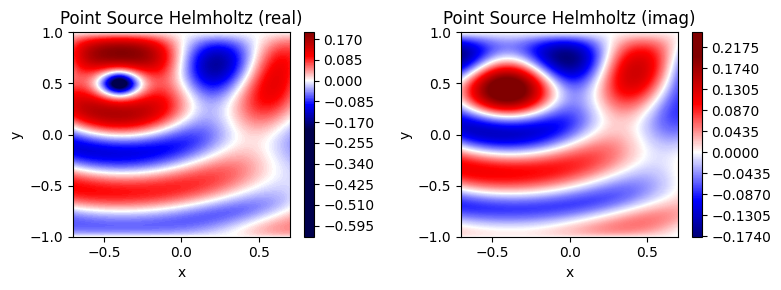

In [75]:
plot_field0(model.to('cpu'), 0.7, Ly)

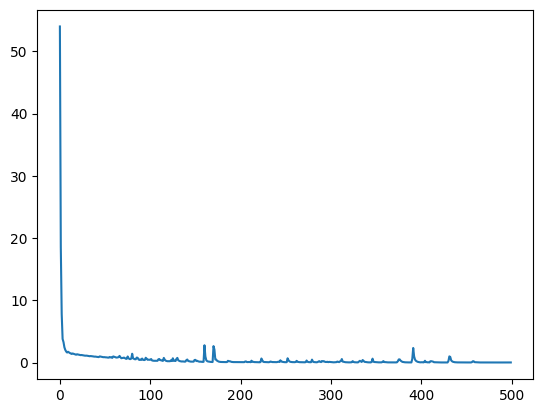

In [76]:
i = 0
loss_list = []
for loss in l_lst:
    loss_list.append(loss.to('cpu').detach().numpy())
np.save('loss.npy', loss_list)
plot_loss(l_lst)

In [77]:
import joblib
joblib.dump(model.state_dict(), 'model_green.joblib')

['model_green.joblib']

In [78]:
def plot_field1(model, Lx, Ly, src=src, k=k):
    N = 200
    x, y = np.linspace(-Lx, Lx, N), np.linspace(-Ly, Ly, N)
    x, y = np.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    g = green(x, y, src, is_tensor=False)
    x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    p0 = model(torch.cat([x, y], dim=-1)).detach().numpy()
    p_real, p_imag = p0[:, 0:1], p0[:, 1:2]

    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_real.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (real)')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1, 2, 2)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_imag.reshape(N, N), levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('Point Source Helmholtz (imag)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('nogreen.jpg')
    plt.tight_layout()

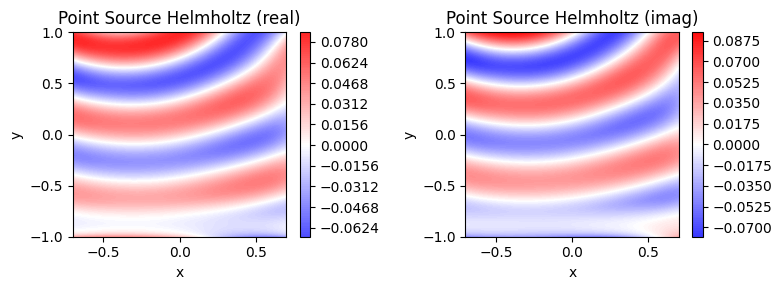

In [79]:
plot_field1(model.to('cpu'), 0.7, Ly)